In [2]:
! pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib
! pip install -U ipywidgets
! pip install numpy==1.26.4
! pip install urllib3==1.26.6

In [3]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, Union, Callable


import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader
from flwr.server.strategy import Strategy
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context, Status, GetParametersRes, Parameters, GetParametersIns, MetricsAggregationFn,NDArrays,Scalar
from flwr.server import ServerApp, ServerConfig, ServerAppComponents 
from flwr.server.strategy import FedAvg, FedProx
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager, SimpleClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.15.2 / PyTorch 2.6.0


In [4]:

BATCH_SIZE = 32

def load_datasets(partition_id, num_partitions: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": num_partitions})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train_test["train"], batch_size=32, shuffle=True)
    valloader = DataLoader(partition_train_test["test"], batch_size=32)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=32)
    return trainloader, valloader, testloader

In [5]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
        
def proxima_train(net, trainloader, epochs: int, proximal_mu:float, global_params:List[torch.Tensor]):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)

            proximal_term = 0.0
            for local_weights, global_weights in zip(net.parameters(), global_params):
                proximal_term += (local_weights - global_weights).norm(2)
            loss = criterion(net(images), labels) + (proximal_mu / 2) * proximal_term


            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def train_moon(net,train_loader, global_net,previous_net, epochs, mu, temperature):
    """Training function for MOON."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    previous_net.eval()
    for param in previous_net.parameters():
        param.requires_grad = False

    cnt = 0
    cos = torch.nn.CosineSimilarity(dim=-1)

    for epoch in range(epochs):
        epoch_loss_collector = []
        epoch_loss1_collector = []
        epoch_loss2_collector = []
        for _, (x, target) in enumerate(train_loader):
            x, target = x, target
            optimizer.zero_grad()
            x.requires_grad = False
            target.requires_grad = False
            target = target.long()

            # pro1 is the representation by the current model (Line 14 of Algorithm 1)
            _, pro1, out = net(x)
            # pro2 is the representation by the global model (Line 15 of Algorithm 1)
            _, pro2, _ = global_net(x)
            # posi is the positive pair
            posi = cos(pro1, pro2)
            logits = posi.reshape(-1, 1)

            # pro 3 is the representation by the previous model (Line 16 of Algorithm 1)
            _, pro3, _ = previous_net(x)
            # nega is the negative pair
            nega = cos(pro1, pro3)
            logits = torch.cat((logits, nega.reshape(-1, 1)), dim=1)

            previous_net.to("cpu")
            logits /= temperature
            labels = torch.zeros(x.size(0)).cuda().long()
            # compute the model-contrastive loss (Line 17 of Algorithm 1)
            loss2 = mu * criterion(logits, labels)
            # compute the cross-entropy loss (Line 13 of Algorithm 1)
            loss1 = criterion(out, target)
            # compute the loss (Line 18 of Algorithm 1)
            loss = loss1 + loss2

            loss.backward()
            optimizer.step()

            cnt += 1
            epoch_loss_collector.append(loss.item())
            epoch_loss1_collector.append(loss1.item())
            epoch_loss2_collector.append(loss2.item())

        epoch_loss = sum(epoch_loss_collector) / len(epoch_loss_collector)
        epoch_loss1 = sum(epoch_loss1_collector) / len(epoch_loss1_collector)
        epoch_loss2 = sum(epoch_loss2_collector) / len(epoch_loss2_collector)
        print(
            "Epoch: %d Loss: %f Loss1: %f Loss2: %f"
            % (epoch, epoch_loss, epoch_loss1, epoch_loss2)
        )






def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

def freeze_layers(model: torch.nn.Module, trainable_layers: int) -> None:
        """Freeze specified layers of the model."""
        for idx, (name, param) in enumerate(model.named_parameters()):
            if idx == trainable_layers or trainable_layers == -1:
                param.requires_grad = True
            else:
                param.requires_grad = False

In [6]:

NETWORK_LEN = len(Net().state_dict().keys())
EPOCHS = 2
NUM_PARTITIONS = 3
NUM_OF_CYCLES  = 1
NUM_OF_FULL_UPDATES_BETWEEN_CYCLES = 5
NUM_OF_ROUNDS = (NUM_OF_CYCLES * NUM_OF_FULL_UPDATES_BETWEEN_CYCLES) + (NUM_OF_CYCLES * NETWORK_LEN *2)
print(f"Number of rounds: {NUM_OF_ROUNDS}")
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}


Number of rounds: 25


In [7]:
from flwr.common import NDArrays, Scalar

def get_evaluate_fn(
    testloader: DataLoader,
    net: torch.nn.Module,
) -> Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]:
    """Return an evaluation function for server-side evaluation."""

    def evaluate(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Use the entire test set for evaluation."""
        
        # Copy model parameters to avoid modifying the original
        net_copy = copy.deepcopy(net)
        
        # Update model with the latest parameters
        params_dict = zip(net_copy.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net_copy.load_state_dict(state_dict, strict=True)
        
        net_copy.to(DEVICE)
        net_copy.eval()

        # Test the model
        loss, accuracy = test(net_copy, testloader)
        
        # Return loss and metrics
        return loss, {"accuracy": accuracy}

    return evaluate

In [8]:
class DropoutClientManager(SimpleClientManager):
    """Custom ClientManager that simulates client dropouts."""
    def __init__(self, dropout_rate: float = 0.4):
        super().__init__()
        self.dropout_rate = dropout_rate

    def sample(
        self,
        num_clients: int,
        min_num_clients: Optional[int] = None,
    ) -> List[ClientProxy]:
        """Sample clients and simulate dropouts."""
        # Get list of clients from parent class
        clients = super().sample(num_clients, min_num_clients)
        
        # Randomly drop clients based on dropout rate
        num_dropouts = int(len(clients) * self.dropout_rate)
        if num_dropouts > 0:
            dropout_indices = np.random.choice(
                len(clients), 
                size=num_dropouts, 
                replace=False
            )
            clients = [c for i, c in enumerate(clients) if i not in dropout_indices]
        
        return clients

# Normal FedAvg

In [9]:
from typing import Union
import sys

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size

fed_avg_result = {}
fed_avg_model_results = {}

class ModifiedFedAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_avg_model_results:
            expand_fed_avg_result= {**fed_avg_model_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_avg_result= {"global_loss": loss, "global_metrics": metrics}

        fed_avg_model_results[server_round] = expand_fed_avg_result

        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        

        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_size": total_size}
        else:
            expand_fed_avg_result= {"total_size": total_size}

        fed_avg_result[server_round] = expand_fed_avg_result


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_avg_result= {"total_loss": total_loss}

        fed_avg_result[server_round] = expand_fed_avg_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [10]:
class NormalFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=EPOCHS)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}



def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return NormalFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [11]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)
client_manager =  DropoutClientManager(dropout_rate=0.5)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=ModifiedFedAvg(
            evaluate_fn=evaluate_fn,
        ),
        client_manager=client_manager
    )
    

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.072174959731102, {'accuracy': 0.1012}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=20963) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=20963)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=20963) [Client 0] fit, config: {}
(ClientAppActor pid=20963) Epoch 1: train loss 0.05986100435256958, accuracy 0.2891322283057076


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=20962) [Client 1] fit, config: {}
(ClientAppActor pid=20963) Epoch 2: train loss 0.049456365406513214, accuracy 0.4208355208880222 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


INFO :      fit progress: (1, 0.054645973587036135, {'accuracy': 0.369}, 18.822559166001156)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=20962) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=20962)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=20962) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 0] fit, config: {}
(ClientAppActor pid=20962) Epoch 2: train loss 0.04974639415740967, accuracy 0.4199354983874597
(ClientAppActor pid=20963) Epoch 1: train loss 0.047034427523612976, accuracy 0.45788644716117904
(ClientAppActor pid=20963) [Client 2] evaluate, config: {}


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=20962) [Client 2] fit, config: {}


INFO :      fit progress: (2, 0.042011599534749984, {'accuracy': 0.5153}, 35.74228433298413)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 2] evaluate, config: {}
(ClientAppActor pid=20962) Epoch 2: train loss 0.043126605451107025, accuracy 0.49947494749474947 [repeated 3x across cluster]


(ClientAppActor pid=20963) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20963)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20962) [Client 0] fit, config: {}
(ClientAppActor pid=20962) [Client 1] evaluate, config: {}
(ClientAppActor pid=20962) Epoch 1: train loss 0.041606105864048004, accuracy 0.5227630690767269
(ClientAppActor pid=20963) Epoch 1: train loss 0.04250781238079071, accuracy 0.5096377409435235
(ClientAppActor pid=20963) [Client 1] fit, config: {}


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (3, 0.03940251121520996, {'accuracy': 0.5492}, 52.087150958017446)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=20962) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20962)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=20962) [Client 1] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 2: train loss 0.03985903784632683, accuracy 0.5418885472136803 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 0] fit, config: {}
(ClientAppActor pid=20963) [Client 0] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 1: train loss 0.03798728063702583, accuracy 0.5623640591014776
(ClientAppActor pid=20962) [Client 1] fit, config: {}
(ClientAppActor pid=20962) Epoch 1: train loss 0.03861416131258011, accuracy 0.5562889072226805


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (4, 0.03788507317900658, {'accuracy': 0.5663}, 68.76647866598796)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=20962) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20962)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=20962) [Client 1] evaluate, config: {}
(ClientAppActor pid=20962) Epoch 2: train loss 0.03617250174283981, accuracy 0.584489612240306 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20962) [Client 2] fit, config: {}
(ClientAppActor pid=20963) [Client 2] evaluate, config: {}
(ClientAppActor pid=20962) Epoch 1: train loss 0.03809994086623192, accuracy 0.566981698169817
(ClientAppActor pid=20963) Epoch 1: train loss 0.03504285216331482, accuracy 0.5980649516237906


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=20963) [Client 0] fit, config: {}


INFO :      fit progress: (5, 0.0364670639693737, {'accuracy': 0.5842}, 84.91799887502566)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 0] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 2: train loss 0.03291085362434387, accuracy 0.6268656716417911 [repeated 2x across cluster]


(ClientAppActor pid=20962) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20962)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20962) [Client 2] fit, config: {}
(ClientAppActor pid=20962) [Client 1] evaluate, config: {}
(ClientAppActor pid=20962) Epoch 1: train loss 0.03463668003678322, accuracy 0.6016351635163516
(ClientAppActor pid=20963) Epoch 1: train loss 0.035520125180482864, accuracy 0.5925148128703217
(ClientAppActor pid=20963) [Client 1] fit, config: {}


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (6, 0.03557033236026764, {'accuracy': 0.6014}, 101.90611695800908)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=20962) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20962)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=20962) [Client 1] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 2: train loss 0.032707713544368744, accuracy 0.6245406135153379 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 0] fit, config: {}
(ClientAppActor pid=20963) [Client 0] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 1: train loss 0.03310130164027214, accuracy 0.6270156753918849
(ClientAppActor pid=20962) [Client 2] fit, config: {}
(ClientAppActor pid=20962) Epoch 1: train loss 0.03188319504261017, accuracy 0.6386138613861386


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (7, 0.03550381728410721, {'accuracy': 0.6046}, 118.55306304100668)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=20962) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20962)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=20962) [Client 1] evaluate, config: {}
(ClientAppActor pid=20962) Epoch 2: train loss 0.029200945049524307, accuracy 0.6665166516651665 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 1] fit, config: {}
(ClientAppActor pid=20963) [Client 2] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 1: train loss 0.03314189612865448, accuracy 0.620790519762994
(ClientAppActor pid=20962) [Client 2] fit, config: {}
(ClientAppActor pid=20962) Epoch 1: train loss 0.0292644165456295, accuracy 0.6648664866486649


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=20962) Epoch 2: train loss 0.026434030383825302, accuracy 0.70004500450045 [repeated 2x across cluster]


INFO :      fit progress: (8, 0.03516462140083313, {'accuracy': 0.6077}, 136.707981457992)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 2] evaluate, config: {}


(ClientAppActor pid=20963) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20963)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20962) [Client 0] fit, config: {}
(ClientAppActor pid=20962) Epoch 1: train loss 0.03139114752411842, accuracy 0.6423160579014475
(ClientAppActor pid=20962) [Client 1] evaluate, config: {}
(ClientAppActor pid=20963) [Client 2] fit, config: {}


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (9, 0.035489644002914426, {'accuracy': 0.6111}, 153.87362604099326)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=20962) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20962)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=20962) [Client 2] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 2: train loss 0.02413957379758358, accuracy 0.7237473747374737 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 0] fit, config: {}
(ClientAppActor pid=20963) [Client 1] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 1: train loss 0.0283733531832695, accuracy 0.6758418960474012
(ClientAppActor pid=20962) Epoch 1: train loss 0.024841880425810814, accuracy 0.7161716171617162
(ClientAppActor pid=20962) [Client 2] fit, config: {}


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (10, 0.03713561220765114, {'accuracy': 0.6114}, 170.8915713329916)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=20962) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20962)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=20962) [Client 0] evaluate, config: {}
(ClientAppActor pid=20962) Epoch 2: train loss 0.022071242332458496, accuracy 0.7491749174917491 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 1] fit, config: {}
(ClientAppActor pid=20963) [Client 2] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 1: train loss 0.03189953789114952, accuracy 0.6348158703967599
(ClientAppActor pid=20962) Epoch 1: train loss 0.023003308102488518, accuracy 0.7384488448844885


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=20962) [Client 2] fit, config: {}


INFO :      fit progress: (11, 0.036400901299715044, {'accuracy': 0.6135}, 187.42343429103494)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 1] evaluate, config: {}
(ClientAppActor pid=20962) Epoch 2: train loss 0.019722914323210716, accuracy 0.7788778877887789 [repeated 2x across cluster]


(ClientAppActor pid=20962) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20962)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 2] fit, config: {}
(ClientAppActor pid=20962) [Client 0] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 1: train loss 0.021037280559539795, accuracy 0.7626012601260126
(ClientAppActor pid=20962) [Client 0] fit, config: {}
(ClientAppActor pid=20962) Epoch 1: train loss 0.028171028941869736, accuracy 0.6795169879246982


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=20962) Epoch 2: train loss 0.023801501840353012, accuracy 0.7287932198304957


INFO :      fit progress: (12, 0.03753483136892319, {'accuracy': 0.6122}, 205.3390708329971)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 1] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 2: train loss 0.017850300297141075, accuracy 0.7971047104710471


(ClientAppActor pid=20963) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20963)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 1] fit, config: {}
(ClientAppActor pid=20963) Epoch 1: train loss 0.029991280287504196, accuracy 0.6564164104102602
(ClientAppActor pid=20962) [Client 2] evaluate, config: {}


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=20962) [Client 0] fit, config: {}


INFO :      fit progress: (13, 0.036432703655958174, {'accuracy': 0.6051}, 221.68173479102552)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 1] evaluate, config: {}
(ClientAppActor pid=20962) Epoch 2: train loss 0.021344240754842758, accuracy 0.7548938723468087 [repeated 3x across cluster]


(ClientAppActor pid=20963) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20963)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20962) [Client 0] fit, config: {}
(ClientAppActor pid=20962) [Client 0] evaluate, config: {}
(ClientAppActor pid=20962) Epoch 1: train loss 0.02243446372449398, accuracy 0.7455186379659492
(ClientAppActor pid=20963) Epoch 1: train loss 0.022335808724164963, accuracy 0.7414491449144914
(ClientAppActor pid=20963) [Client 2] fit, config: {}


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (14, 0.04016649128198624, {'accuracy': 0.61}, 239.54414950002683)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 0] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 2: train loss 0.017584573477506638, accuracy 0.79995499549955 [repeated 2x across cluster]


(ClientAppActor pid=20963) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20963)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 1] fit, config: {}
(ClientAppActor pid=20962) [Client 1] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 1: train loss 0.02846011333167553, accuracy 0.6750168754218856
(ClientAppActor pid=20962) [Client 0] fit, config: {}
(ClientAppActor pid=20962) Epoch 1: train loss 0.020273612812161446, accuracy 0.7657691442286058


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (15, 0.03821652182042599, {'accuracy': 0.613}, 256.5520622910117)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=20962) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20962)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=20962) [Client 0] evaluate, config: {}
(ClientAppActor pid=20962) Epoch 2: train loss 0.016640610992908478, accuracy 0.8100202505062627 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 0] fit, config: {}
(ClientAppActor pid=20963) [Client 2] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 1: train loss 0.018332481384277344, accuracy 0.7896197404935124
(ClientAppActor pid=20962) [Client 1] fit, config: {}
(ClientAppActor pid=20962) Epoch 1: train loss 0.024614665657281876, accuracy 0.7203180079501987


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=20963) Epoch 2: train loss 0.01519060879945755, accuracy 0.8262956573914347
(ClientAppActor pid=20962) Epoch 2: train loss 0.02079419046640396, accuracy 0.7644941123528088


INFO :      fit progress: (16, 0.04080932109951973, {'accuracy': 0.6081}, 274.73283995798556)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=20962) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20962)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=20962) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 0] fit, config: {}
(ClientAppActor pid=20963) Epoch 1: train loss 0.01683194376528263, accuracy 0.8056701417535438
(ClientAppActor pid=20963) [Client 1] evaluate, config: {}
(ClientAppActor pid=20962) [Client 1] fit, config: {}


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (17, 0.04360512877702713, {'accuracy': 0.6092}, 292.7454991249833)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 1] evaluate, config: {}
(ClientAppActor pid=20962) Epoch 2: train loss 0.018394991755485535, accuracy 0.7908197704942623 [repeated 3x across cluster]


(ClientAppActor pid=20962) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20962)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 0] fit, config: {}
(ClientAppActor pid=20962) [Client 2] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 1: train loss 0.015256626531481743, accuracy 0.8228455711392785
(ClientAppActor pid=20962) Epoch 1: train loss 0.01991673745214939, accuracy 0.7689942248556214


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=20962) Epoch 2: train loss 0.015825502574443817, accuracy 0.8172954323858096
(ClientAppActor pid=20962) [Client 1] fit, config: {}


INFO :      fit progress: (18, 0.04708843239545822, {'accuracy': 0.599}, 308.1141565410071)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=20962) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20962)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=20962) [Client 2] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 2: train loss 0.01177452877163887, accuracy 0.8656716417910447


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 0] fit, config: {}
(ClientAppActor pid=20963) Epoch 1: train loss 0.014003366231918335, accuracy 0.8399459986499662
(ClientAppActor pid=20963) [Client 0] evaluate, config: {}
(ClientAppActor pid=20962) [Client 2] fit, config: {}


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=20962) Epoch 2: train loss 0.02014831081032753, accuracy 0.771002100210021 [repeated 3x across cluster]


INFO :      fit progress: (19, 0.04615727836787701, {'accuracy': 0.5974}, 324.72783662501024)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 2] evaluate, config: {}


(ClientAppActor pid=20962) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20962)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20962) [Client 1] fit, config: {}
(ClientAppActor pid=20962) Epoch 1: train loss 0.021254634484648705, accuracy 0.7548188704717618
(ClientAppActor pid=20962) [Client 0] evaluate, config: {}


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=20963) [Client 2] fit, config: {}


INFO :      fit progress: (20, 0.044469562631845476, {'accuracy': 0.6086}, 340.5510913330363)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 1] evaluate, config: {}
(ClientAppActor pid=20962) Epoch 2: train loss 0.016015445813536644, accuracy 0.8182704567614191 [repeated 3x across cluster]


(ClientAppActor pid=20963) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20963)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=20962, ip=127.0.0.1, actor_id=2ac6eb32a92d2e33b0a162d501000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x108531a90>)
  File "/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 504 Server Error: Gateway Time-out for url: https://huggingface.co/api/datasets/cifar10/paths-info/0b2714987fa478483af9968de7c934580d0bb9a2

The above exception was the

(ClientAppActor pid=20962) [Client 0] fit, config: {}
(ClientAppActor pid=20962) Epoch 1: train loss 0.016116267070174217, accuracy 0.8123453086327158


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=20963) [Client 2] fit, config: {}
(ClientAppActor pid=20963) Epoch 2: train loss 0.013985791243612766, accuracy 0.8412091209120912 [repeated 3x across cluster]


INFO :      fit progress: (21, 0.04927322534918785, {'accuracy': 0.5976}, 375.7885157910059)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=20962, ip=127.0.0.1, actor_id=2ac6eb32a92d2e33b0a162d501000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x108531a90>)
  File "/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 504 Server Error: Gateway Time-out for url: https://huggingface.co/api/datasets/cifar10/paths-info/0b2714987fa478483af9968de7c934580d0bb9a2

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=20962, ip=127.0.0.1, actor_id=2ac6eb32a92d2e33b0a162d501000000, repr=<flwr.simulation.ray_transport.ray_acto

(ClientAppActor pid=20963) [Client 0] fit, config: {}


(ClientAppActor pid=20963) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=20963)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=20963) Epoch 1: train loss 0.013261951506137848, accuracy 0.8457211430285757
(ClientAppActor pid=20963) Epoch 2: train loss 0.009254518896341324, accuracy 0.8947723693092328


(ClientAppActor pid=20962) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=20962)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=20962) [Client 1] fit, config: {}
(ClientAppActor pid=20962) Epoch 1: train loss 0.0210132859647274, accuracy 0.7575189379734494


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=20962) Epoch 2: train loss 0.015034940093755722, accuracy 0.8319207980199504


INFO :      fit progress: (22, 0.050665516394376754, {'accuracy': 0.5998}, 420.8684127909946)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=20962) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=20962)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=20963) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=20963)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=20962) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20962) [Client 1] fit, config: {}
(ClientAppActor pid=20962) Epoch 1: train loss 0.016784068197011948, accuracy 0.8053701342533564
(ClientAppActor pid=20963) [Client 1] evaluate, config: {}


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=20963) [Client 0] fit, config: {}


INFO :      fit progress: (23, 0.055444347837567326, {'accuracy': 0.6003}, 436.8161956249969)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 0] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 2: train loss 0.008113502524793148, accuracy 0.9129228230705768 [repeated 3x across cluster]


(ClientAppActor pid=20962) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=20962)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 2] fit, config: {}
(ClientAppActor pid=20962) [Client 1] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 1: train loss 0.022823002189397812, accuracy 0.7402490249024902
(ClientAppActor pid=20962) Epoch 1: train loss 0.014837315306067467, accuracy 0.8319957998949974


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=20962) [Client 1] fit, config: {}


INFO :      fit progress: (24, 0.05107465441823006, {'accuracy': 0.5957}, 452.20318516599946)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 1] evaluate, config: {}
(ClientAppActor pid=20962) Epoch 2: train loss 0.010968982242047787, accuracy 0.8779719492987325 [repeated 2x across cluster]


(ClientAppActor pid=20963) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20963)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20962) [Client 1] fit, config: {}
(ClientAppActor pid=20962) [Client 0] evaluate, config: {}
(ClientAppActor pid=20962) Epoch 1: train loss 0.012813066132366657, accuracy 0.8507462686567164
(ClientAppActor pid=20963) [Client 2] fit, config: {}
(ClientAppActor pid=20963) Epoch 1: train loss 0.017399990931153297, accuracy 0.800930093009301


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (25, 0.05499998914599419, {'accuracy': 0.5961}, 468.45941791601945)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=20963) [Client 1] evaluate, config: {}
(ClientAppActor pid=20963) Epoch 2: train loss 0.012539887800812721, accuracy 0.8536603660366037 [repeated 2x across cluster]


(ClientAppActor pid=20963) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=20963)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 471.98s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.055458676335907446
INFO :      		round 2: 0.0431170527922156
INFO :      		round 3: 0.0402484002428707
INFO :      		round 4: 0.03910140083554125
INFO :      		round 5: 0.03751148528407703
INFO :      		round 6: 0.03636197648365911
INFO :      		round 7: 0.03655930946848674
INFO :      		round 8: 0.035837404604221294
INFO :      		round 9: 0.036397323155374535
INFO :      		round 10: 0.038333082420781615
INFO :      		round 11: 0.03748

(ClientAppActor pid=20962) [Client 2] evaluate, config: {}


(ClientAppActor pid=20962) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=20962)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


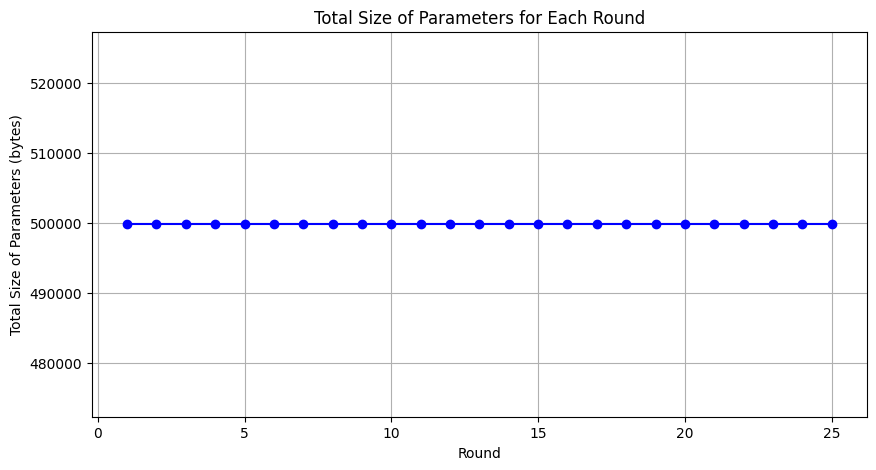

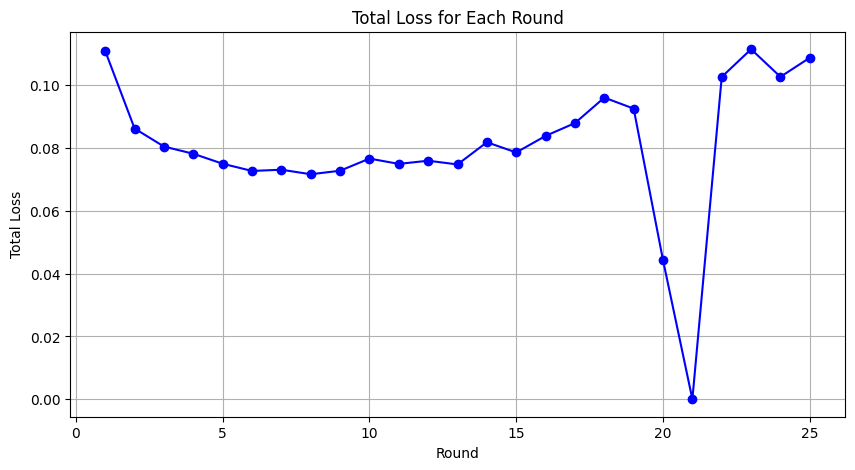

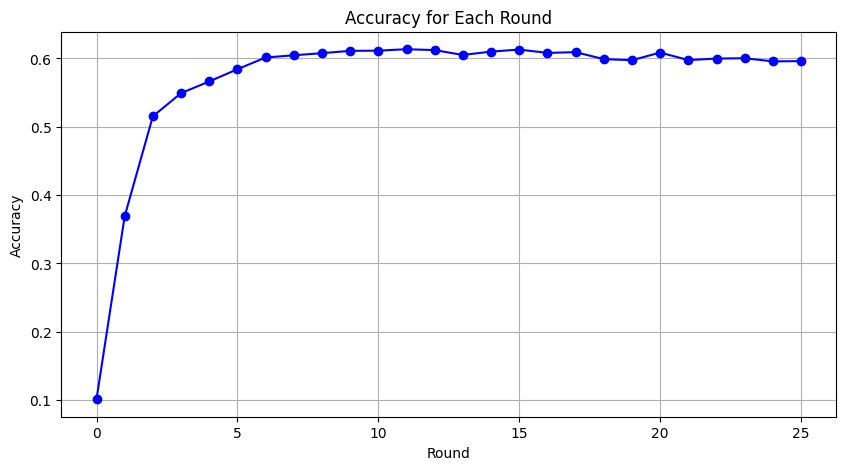

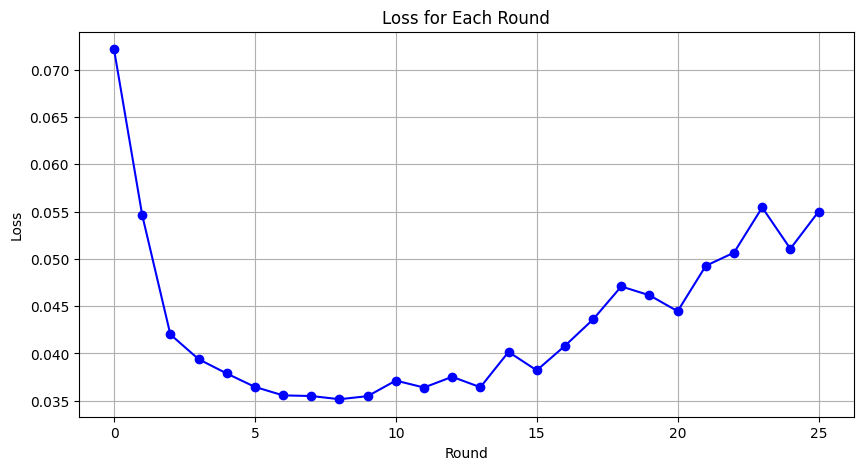

In [14]:
import matplotlib.pyplot as plt
import numpy as np


fed_avg_rounds = list(fed_avg_result.keys())
fed_avg_sizes = [fed_avg_result[round]["total_size"] for round in fed_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.grid(True)

fed_avg_losses = [fed_avg_result[round].get("total_loss") if fed_avg_result[round].get("total_loss") else 0 for round in fed_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.grid(True)

fed_avg_model_rounds = list(fed_avg_model_results.keys())

fed_avg_accuracies = [fed_avg_model_results[round]["global_metrics"]["accuracy"] for round in fed_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.grid(True)

fed_avg_global_losses = [fed_avg_model_results[round]["global_loss"] for round in fed_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss for Each Round')
plt.grid(True)

# FedAvgPart Experiments

In [15]:
from typing import Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

fed_part_avg_result = {}

fed_part_avg_model_results = {}


class FedPartAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace

        self.layer_update_strategy = layer_update_strategy  # 'sequential' or 'cyclic'
        self.current_layer = 0  # Track which layer to update
        self.number_of_layers = None
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
    def generate_layer_training_sequence(self) -> List[int]:
        """Generate a sequence of layers to train."""
        layer_training_sequence = []
        for _ in range(NUM_OF_CYCLES):
            for _ in range(NUM_OF_FULL_UPDATES_BETWEEN_CYCLES):
                    layer_training_sequence.append(-1)
            for layer in range(NETWORK_LEN):
                    layer_training_sequence.append(layer)
                    layer_training_sequence.append(layer)

        return layer_training_sequence

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        self.layer_training_sequence = self.generate_layer_training_sequence()
        self.number_of_layers = len(ndarrays)

        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_part_avg_model_results:  
            expand_fed_part_avg_model_results= {**fed_part_avg_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_part_avg_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_part_avg_model_results[server_round] = expand_fed_part_avg_model_results
        
        loss, metrics = eval_res
        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {"trainable_layers": self.layer_training_sequence[self.training_sequence_index]}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        print(f"Training on layer {self.layer_training_sequence}")
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_part_avg_result.get(server_round):
            fed_part_avg_result[server_round]["total_size"] = total_size
        else:
            fed_part_avg_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        aggregated_weights = aggregate(weights_results)
        # parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        if self.layer_training_sequence[self.training_sequence_index -1] == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            current_model[self.layer_training_sequence[self.training_sequence_index -1]] = aggregated_weights[0]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_part_avg_result.get(server_round):
            fed_part_avg_result[server_round]["total_loss"] = total_loss
        else:
            fed_part_avg_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    

In [16]:
class FedAvgPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = parameters[config["trainable_layers"]]
        return [trained_layer]

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        freeze_layers(self.net, config["trainable_layers"])
        train(self.net, self.trainloader, epochs=EPOCHS)
        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedAvgPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [17]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)
client_manager =  DropoutClientManager(dropout_rate=0.5)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedPartAvg(
            evaluate_fn=evaluate_fn,
        ),
        client_manager=client_manager
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07221359026432038, {'accuracy': 0.0912}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]


(ClientAppActor pid=34690) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=34690)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=34690) [Client 1] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=34690) Epoch 1: train loss 0.05877161771059036, accuracy 0.3087077176929423
(ClientAppActor pid=34692) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=34690) [Client 1] get_parameters
(ClientAppActor pid=34690) Epoch 2: train loss 0.04955334588885307, accuracy 0.41656041401035027 [repeated 2x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 499840


INFO :      fit progress: (1, 0.052324393355846405, {'accuracy': 0.4023}, 20.974025374976918)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34692) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=34692)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=34692) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34692) [Client 1] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=34692) [Client 0] get_parameters
(ClientAppActor pid=34692) Epoch 2: train loss 0.04931861162185669, accuracy 0.4260856521413035
(ClientAppActor pid=34690) Epoch 1: train loss 0.046920232474803925, accuracy 0.44971124278106955
(ClientAppActor pid=34690) [Client 1] evaluate, config: {}
(ClientAppActor pid=34690) [Client 0] fit, config: {'trainable_layers': -1}


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=34690) [Client 0] get_parameters
(ClientAppActor pid=34690) Epoch 2: train loss 0.043869830667972565, accuracy 0.488787219680492 [repeated 2x across cluster]
total size: 499840


INFO :      fit progress: (2, 0.04269041848778725, {'accuracy': 0.5073}, 39.715214124997146)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34690) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34690)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34690) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34692) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=34692) [Client 1] get_parameters
(ClientAppActor pid=34692) Epoch 2: train loss 0.04387900233268738, accuracy 0.48953723843096075
(ClientAppActor pid=34690) Epoch 1: train loss 0.04220127314329147, accuracy 0.5149628740718518
(ClientAppActor pid=34692) [Client 1] evaluate, config: {}
(ClientAppActor pid=34690) [Client 1] fit, config: {'trainable_layers': -1}


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=34690) [Client 1] get_parameters
(ClientAppActor pid=34692) Epoch 2: train loss 0.039849959313869476, accuracy 0.5442136053401335 [repeated 3x across cluster]
total size: 499840


INFO :      fit progress: (3, 0.04018694112896919, {'accuracy': 0.5386}, 56.983952082984615)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34692) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34692)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34692) [Client 0] evaluate, config: {}
(ClientAppActor pid=34692) [Client 0] get_parameters


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34692) [Client 2] fit, config: {'trainable_layers': -1}


(ClientAppActor pid=34690) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=34690)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=34690) [Client 1] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 1: train loss 0.04084748029708862, accuracy 0.5324782478247825
(ClientAppActor pid=34690) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=34692) [Client 2] get_parameters
(ClientAppActor pid=34692) Epoch 2: train loss 0.03790803626179695, accuracy 0.5645814581458146 [repeated 2x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 499840


INFO :      fit progress: (4, 0.03875150535702705, {'accuracy': 0.5605}, 77.19898154097609)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34692) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=34692)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=34690) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=34690)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=34692) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34692) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=34690) [Client 0] get_parameters
(ClientAppActor pid=34690) Epoch 2: train loss 0.036319442093372345, accuracy 0.5824645616140404
(ClientAppActor pid=34692) Epoch 1: train loss 0.03608512878417969, accuracy 0.5845646141153529
(ClientAppActor pid=34690) [Client 1] evaluate, config: {}
(ClientAppActor pid=34690) [Client 1] fit, config: {'trainable_layers': -1}


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=34690) [Client 1] get_parameters
(ClientAppActor pid=34690) Epoch 2: train loss 0.03521500900387764, accuracy 0.5998649966249157 [repeated 2x across cluster]
total size: 499840


INFO :      fit progress: (5, 0.03731638166308403, {'accuracy': 0.5821}, 94.57586249994347)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34692) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=34692)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=34692) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34690) [Client 0] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=34692) [Client 0] get_parameters
(ClientAppActor pid=34692) Epoch 2: train loss 0.033669594675302505, accuracy 0.6169654241356034
(ClientAppActor pid=34690) Epoch 1: train loss 0.03154877945780754, accuracy 0.6456161404035101
(ClientAppActor pid=34690) [Client 1] evaluate, config: {}
(ClientAppActor pid=34690) [Client 0] get_parameters
(ClientAppActor pid=34692) [Client 2] fit, config: {'trainable_layers': 0}


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 4302


INFO :      fit progress: (6, 0.0370743297457695, {'accuracy': 0.5855}, 110.26377158297691)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34692) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34692)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34692) [Client 0] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 2: train loss 0.03526299074292183, accuracy 0.6017101710171017 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34692) [Client 1] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=34692) [Client 2] get_parameters
(ClientAppActor pid=34690) [Client 1] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 1: train loss 0.033095844089984894, accuracy 0.6242406060151504
(ClientAppActor pid=34690) Epoch 1: train loss 0.035261332988739014, accuracy 0.5999099909990999


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=34690) Epoch 2: train loss 0.035168662667274475, accuracy 0.6020852085208521
(ClientAppActor pid=34690) [Client 2] get_parameters
(ClientAppActor pid=34690) [Client 2] fit, config: {'trainable_layers': 0}
total size: 4302


INFO :      fit progress: (7, 0.03694005261063576, {'accuracy': 0.5874}, 125.83857087499928)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34692) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34692)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34692) [Client 1] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 2: train loss 0.032964471727609634, accuracy 0.6258906472661817


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34692) [Client 2] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=34692) [Client 1] get_parameters
(ClientAppActor pid=34692) Epoch 1: train loss 0.03486109524965286, accuracy 0.6066606660666066
(ClientAppActor pid=34690) [Client 2] evaluate, config: {}
(ClientAppActor pid=34692) [Client 2] get_parameters
(ClientAppActor pid=34690) [Client 1] fit, config: {'trainable_layers': 1}


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 750


INFO :      fit progress: (8, 0.036922999042272565, {'accuracy': 0.5877}, 138.7642581659602)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34692) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34692)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34692) [Client 2] evaluate, config: {}
(ClientAppActor pid=34690) Epoch 2: train loss 0.032697875052690506, accuracy 0.6297157428935723 [repeated 3x across cluster]


(ClientAppActor pid=34690) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=34690)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=34690) [Client 1] get_parameters
(ClientAppActor pid=34690) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]


(ClientAppActor pid=34690) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=34690)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=34690) [Client 0] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=34690) Epoch 1: train loss 0.031210532411932945, accuracy 0.6487662191554789
(ClientAppActor pid=34690) [Client 0] get_parameters
(ClientAppActor pid=34692) [Client 1] fit, config: {'trainable_layers': 1}


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 750


INFO :      fit progress: (9, 0.03693964838981628, {'accuracy': 0.5876}, 157.28150516597088)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34690) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=34690)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=34690) [Client 2] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 2: train loss 0.032704245299100876, accuracy 0.6304657616440411 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34692) [Client 0] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=34692) [Client 1] get_parameters
(ClientAppActor pid=34692) [Client 1] evaluate, config: {}
(ClientAppActor pid=34690) Epoch 1: train loss 0.035106271505355835, accuracy 0.6003600360036003
(ClientAppActor pid=34692) Epoch 1: train loss 0.031351957470178604, accuracy 0.6477911947798695
(ClientAppActor pid=34690) [Client 2] get_parameters
(ClientAppActor pid=34690) [Client 2] fit, config: {'trainable_layers': 2}


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 19902


INFO :      fit progress: (10, 0.036516479498147965, {'accuracy': 0.5907}, 170.3234949579928)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34692) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34692)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34692) [Client 1] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 2: train loss 0.03107396326959133, accuracy 0.6497412435310883 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34692) [Client 2] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=34692) [Client 0] get_parameters
(ClientAppActor pid=34690) [Client 2] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 1: train loss 0.03460433706641197, accuracy 0.61003600360036
(ClientAppActor pid=34690) Epoch 1: train loss 0.03300565108656883, accuracy 0.6253656341408536


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=34692) [Client 2] get_parameters
(ClientAppActor pid=34690) [Client 1] fit, config: {'trainable_layers': 2}
total size: 19902


INFO :      fit progress: (11, 0.03655121500492096, {'accuracy': 0.5897}, 182.80446541594574)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34692) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34692)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34692) [Client 2] evaluate, config: {}
(ClientAppActor pid=34690) Epoch 2: train loss 0.03265335038304329, accuracy 0.628665716642916 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34692) [Client 2] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=34690) [Client 1] get_parameters
(ClientAppActor pid=34690) [Client 0] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 1: train loss 0.03367513418197632, accuracy 0.6174617461746175
(ClientAppActor pid=34690) Epoch 1: train loss 0.03200893476605415, accuracy 0.637815945398635


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=34692) [Client 2] get_parameters
(ClientAppActor pid=34690) [Client 1] fit, config: {'trainable_layers': 3}
total size: 830


INFO :      fit progress: (12, 0.03629006527066231, {'accuracy': 0.5932}, 194.84483154094778)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34690) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34690)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34690) [Client 0] evaluate, config: {}
(ClientAppActor pid=34690) Epoch 2: train loss 0.03192128613591194, accuracy 0.6386409660241507 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34692) [Client 0] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=34690) [Client 1] get_parameters
(ClientAppActor pid=34692) [Client 1] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 1: train loss 0.030829694122076035, accuracy 0.6530413260331508
(ClientAppActor pid=34690) Epoch 1: train loss 0.0319279320538044, accuracy 0.6383409585239631


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=34690) Epoch 2: train loss 0.03189519792795181, accuracy 0.6390909772744319
(ClientAppActor pid=34690) [Client 1] get_parameters
(ClientAppActor pid=34690) [Client 1] fit, config: {'trainable_layers': 3}
total size: 830


INFO :      fit progress: (13, 0.03630681555271149, {'accuracy': 0.5932}, 207.40675720799481)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34692) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34692)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34692) [Client 0] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 2: train loss 0.030798424035310745, accuracy 0.6540163504087603


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34690) [Client 1] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=34692) [Client 0] get_parameters
(ClientAppActor pid=34690) Epoch 1: train loss 0.032838594168424606, accuracy 0.6261156528913223
(ClientAppActor pid=34690) [Client 2] evaluate, config: {}
(ClientAppActor pid=34690) [Client 1] get_parameters
(ClientAppActor pid=34692) [Client 2] fit, config: {'trainable_layers': 4}


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 384702


INFO :      fit progress: (14, 0.03602900013923645, {'accuracy': 0.5954}, 220.2052547079511)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34692) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34692)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34692) [Client 0] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 2: train loss 0.03174009919166565, accuracy 0.6405640564056405 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34690) [Client 1] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=34692) [Client 2] get_parameters
(ClientAppActor pid=34690) [Client 1] evaluate, config: {}
(ClientAppActor pid=34690) Epoch 1: train loss 0.030933687463402748, accuracy 0.645091127278182
(ClientAppActor pid=34692) Epoch 1: train loss 0.03200043737888336, accuracy 0.6386888688868887
(ClientAppActor pid=34690) [Client 1] get_parameters
(ClientAppActor pid=34692) [Client 2] fit, config: {'trainable_layers': 4}


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 384702


INFO :      fit progress: (15, 0.035760852283239365, {'accuracy': 0.6015}, 232.4820474999724)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34692) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34692)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34692) [Client 0] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 2: train loss 0.029924022033810616, accuracy 0.6604410441044104 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34690) [Client 0] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=34692) [Client 2] get_parameters
(ClientAppActor pid=34690) [Client 1] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 1: train loss 0.028216946870088577, accuracy 0.6803420085502138
(ClientAppActor pid=34690) Epoch 1: train loss 0.03178631514310837, accuracy 0.6382659566489163


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=34690) Epoch 2: train loss 0.0316542387008667, accuracy 0.6393909847746194
(ClientAppActor pid=34690) [Client 0] get_parameters
(ClientAppActor pid=34692) [Client 1] fit, config: {'trainable_layers': 5}
total size: 1662


INFO :      fit progress: (16, 0.03547735531926155, {'accuracy': 0.6051}, 244.4580503749894)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34690) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34690)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34690) [Client 2] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 2: train loss 0.028072988614439964, accuracy 0.6830420760519013


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34692) [Client 1] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=34692) [Client 1] get_parameters
(ClientAppActor pid=34692) Epoch 1: train loss 0.02804526314139366, accuracy 0.6831170779269482
(ClientAppActor pid=34692) [Client 0] evaluate, config: {}


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=34692) [Client 1] get_parameters
(ClientAppActor pid=34690) [Client 2] fit, config: {'trainable_layers': 5}
total size: 1662


INFO :      fit progress: (17, 0.035436857497692105, {'accuracy': 0.6069}, 256.55375708296197)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34692) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34692)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34692) [Client 2] evaluate, config: {}
(ClientAppActor pid=34690) Epoch 2: train loss 0.028911925852298737, accuracy 0.6750675067506751 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34692) [Client 1] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=34690) [Client 2] get_parameters
(ClientAppActor pid=34690) [Client 1] evaluate, config: {}
(ClientAppActor pid=34690) Epoch 1: train loss 0.029069893062114716, accuracy 0.6725922592259226
(ClientAppActor pid=34692) Epoch 1: train loss 0.028118200600147247, accuracy 0.6831170779269482


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=34690) [Client 2] get_parameters
(ClientAppActor pid=34690) [Client 2] fit, config: {'trainable_layers': 6}
total size: 81342


INFO :      fit progress: (18, 0.03583741421103478, {'accuracy': 0.6071}, 268.5789772499702)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34692) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34692)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34692) [Client 1] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 2: train loss 0.027443623170256615, accuracy 0.6907672691817296 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34692) [Client 1] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=34692) [Client 1] get_parameters
(ClientAppActor pid=34690) [Client 2] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 1: train loss 0.027495428919792175, accuracy 0.6900922523063077
(ClientAppActor pid=34690) Epoch 1: train loss 0.031721148639917374, accuracy 0.6398409960249006


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 81342
(ClientAppActor pid=34692) [Client 1] get_parameters
(ClientAppActor pid=34690) [Client 0] fit, config: {'trainable_layers': 6}


INFO :      fit progress: (19, 0.03563884751200676, {'accuracy': 0.606}, 280.8020577499992)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34690) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34690)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34690) [Client 1] evaluate, config: {}
(ClientAppActor pid=34690) Epoch 2: train loss 0.03103107400238514, accuracy 0.6498912472811821 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34692) [Client 1] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=34690) [Client 0] get_parameters
(ClientAppActor pid=34692) [Client 0] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 1: train loss 0.026853928342461586, accuracy 0.6988674716867922
(ClientAppActor pid=34690) Epoch 1: train loss 0.028483476489782333, accuracy 0.680918091809181
(ClientAppActor pid=34692) [Client 1] get_parameters
(ClientAppActor pid=34690) [Client 2] fit, config: {'trainable_layers': 7}


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 1374


INFO :      fit progress: (20, 0.03557885736227036, {'accuracy': 0.6057}, 292.63597549998667)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34690) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34690)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34690) [Client 0] evaluate, config: {}
(ClientAppActor pid=34690) Epoch 2: train loss 0.028402814641594887, accuracy 0.6813681368136814 [repeated 2x across cluster]
(ClientAppActor pid=34690) [Client 2] get_parameters


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34692) [Client 1] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=34692) [Client 2] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 1: train loss 0.02679433487355709, accuracy 0.6993924848121204
(ClientAppActor pid=34690) Epoch 1: train loss 0.02840089425444603, accuracy 0.6812181218121812


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=34692) [Client 1] get_parameters
(ClientAppActor pid=34690) [Client 2] fit, config: {'trainable_layers': 7}
total size: 1374


INFO :      fit progress: (21, 0.03561951659321785, {'accuracy': 0.6061}, 304.8815078329644)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34692) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34692)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34692) [Client 1] evaluate, config: {}
(ClientAppActor pid=34690) Epoch 2: train loss 0.028379859402775764, accuracy 0.6801680168016802 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34690) [Client 1] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=34690) [Client 2] get_parameters
(ClientAppActor pid=34690) [Client 0] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 1: train loss 0.028499050065875053, accuracy 0.6798679867986799
(ClientAppActor pid=34690) Epoch 1: train loss 0.026900261640548706, accuracy 0.696542413560339


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 7422
(ClientAppActor pid=34692) [Client 2] get_parameters
(ClientAppActor pid=34692) [Client 2] fit, config: {'trainable_layers': 8}


INFO :      fit progress: (22, 0.03623740190267563, {'accuracy': 0.6071}, 316.5032048749854)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34692) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34692)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34692) [Client 2] evaluate, config: {}
(ClientAppActor pid=34690) Epoch 2: train loss 0.026730841025710106, accuracy 0.6991674791869796 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34690) [Client 0] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=34690) [Client 1] get_parameters
(ClientAppActor pid=34690) [Client 0] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 1: train loss 0.026748644188046455, accuracy 0.6986424660616516
(ClientAppActor pid=34690) Epoch 1: train loss 0.031141800805926323, accuracy 0.6494412360309008


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=34692) [Client 1] get_parameters
(ClientAppActor pid=34692) [Client 1] fit, config: {'trainable_layers': 8}
total size: 7422


INFO :      fit progress: (23, 0.035933411580324176, {'accuracy': 0.6058}, 328.3099233749672)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34690) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34690)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34690) [Client 0] evaluate, config: {}
(ClientAppActor pid=34690) Epoch 2: train loss 0.030893098562955856, accuracy 0.6494412360309008 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34692) [Client 0] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=34690) [Client 0] get_parameters
(ClientAppActor pid=34692) [Client 1] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 1: train loss 0.03089134767651558, accuracy 0.6536413410335259
(ClientAppActor pid=34690) Epoch 1: train loss 0.026575926691293716, accuracy 0.7014175354383859


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=34692) [Client 0] get_parameters
(ClientAppActor pid=34690) [Client 1] fit, config: {'trainable_layers': 9}
total size: 782


INFO :      fit progress: (24, 0.03588262417316437, {'accuracy': 0.6072}, 340.33660412498284)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34690) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34690)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34690) [Client 0] evaluate, config: {}
(ClientAppActor pid=34690) Epoch 2: train loss 0.026530366390943527, accuracy 0.7018675466886672 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=34692) [Client 0] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=34690) [Client 1] get_parameters
(ClientAppActor pid=34692) [Client 1] evaluate, config: {}
(ClientAppActor pid=34692) Epoch 1: train loss 0.030865132808685303, accuracy 0.6531163279081977
(ClientAppActor pid=34690) Epoch 1: train loss 0.028295861557126045, accuracy 0.6812931293129313
(ClientAppActor pid=34692) [Client 0] get_parameters
(ClientAppActor pid=34690) [Client 2] fit, config: {'trainable_layers': 9}


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 782


INFO :      fit progress: (25, 0.035878335916996004, {'accuracy': 0.6071}, 352.0864927499788)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=34692) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=34692)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=34692) [Client 1] evaluate, config: {}
(ClientAppActor pid=34690) Epoch 2: train loss 0.028293514624238014, accuracy 0.6815181518151815 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 354.98s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0527335014719411
INFO :      		round 2: 0.04367998881510223
INFO :      		round 3: 0.04077842701103562
INFO :      		round 4: 0.03949090536297189
INFO :      		round 5: 0.037686852437690405
INFO :      		round 6: 0.037432662262198595
INFO :      		round 7: 0.0375617681396315
INFO :      		round 8: 0.03747778077038305
INFO :      		round 9: 0.03750866172409515
INFO :      		round 10: 0.03717135414972804
INFO :      		round 11: 0.03749350439164906
INFO :      		round 12: 0.03655826850572459
INFO :      		round 13: 0.03723859458035456
INFO :      		round 14: 0.03653703565610407
INFO :      		round 15: 0.03622977950469991
INFO :      		round 16: 0.03634261192857826
INFO :      		round 17: 0.036164418175753964
INFO :      		round 18: 0.03656646939152075
INFO :      		round 19: 0

(ClientAppActor pid=34690) [Client 2] get_parameters
(ClientAppActor pid=34690) [Client 0] evaluate, config: {}


(ClientAppActor pid=34690) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=34690)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


Text(0.5, 1.0, 'Loss for Each Round')

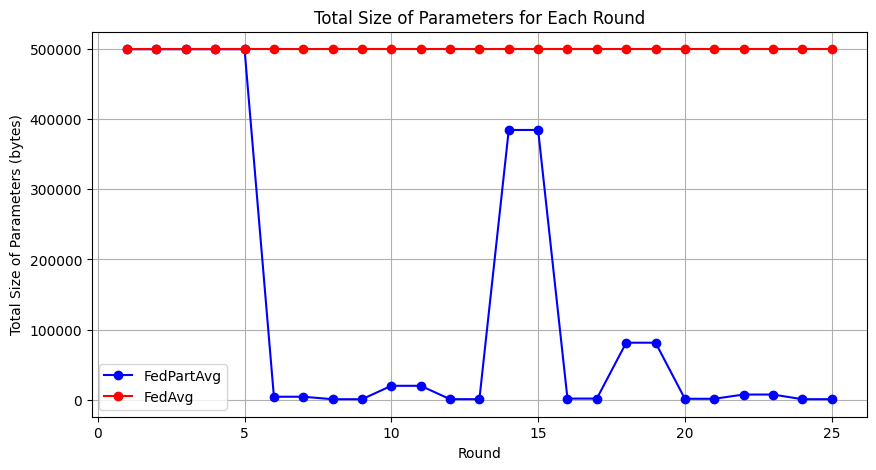

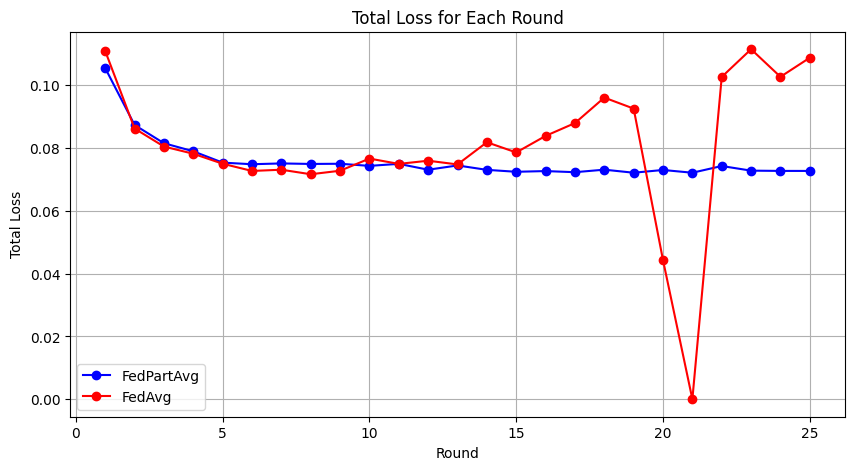

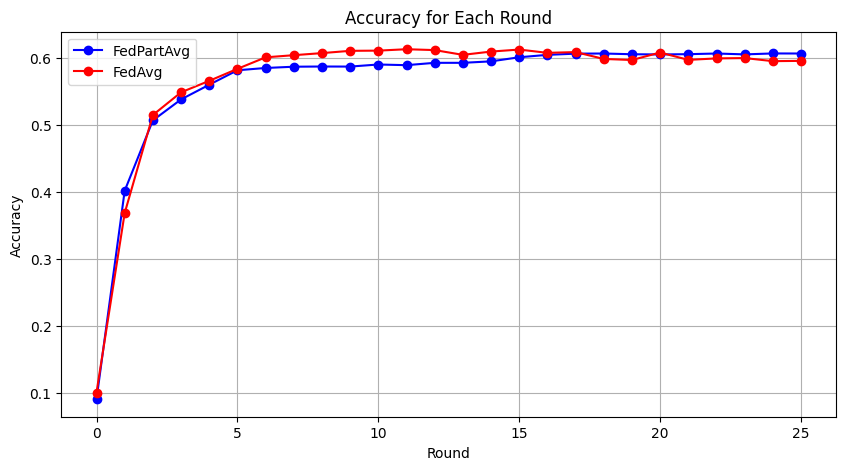

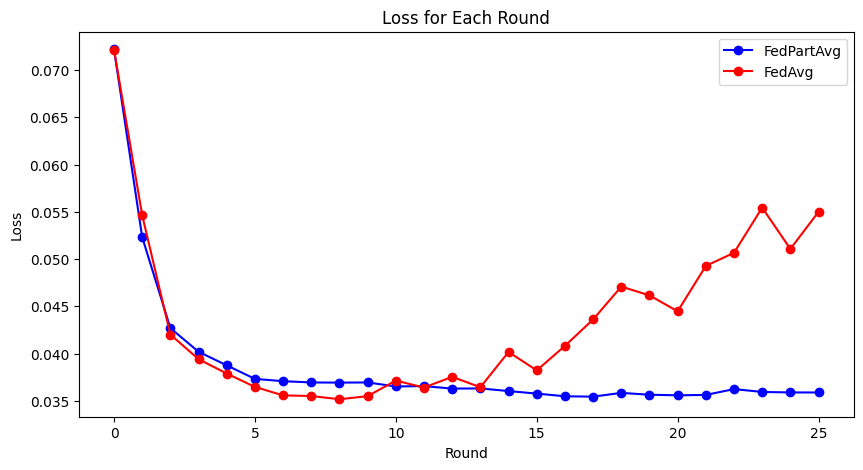

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the total size of parameters for each round
fed_part_avg_rounds = list(fed_part_avg_result.keys())
fed_part_avg_sizes = [fed_part_avg_result[round]["total_size"] for round in fed_part_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='b', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.legend()
plt.grid(True)

fed_part_avg_losses = [fed_part_avg_result[round]["total_loss"] for round in fed_part_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='b', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.legend()
plt.grid(True)


fed_part_avg_model_rounds = list(fed_part_avg_model_results.keys())
fed_part_avg_accuracies = [fed_part_avg_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='b', label='FedPartAvg')
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_part_avg_global_losses = [fed_part_avg_model_results[round]["global_loss"] for round in fed_part_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='b', label='FedPartAvg')
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss for Each Round')


# FedProxPart Experiments

In [19]:
class FedProxPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = parameters[config["trainable_layers"]]
        return [trained_layer]

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        global_params = copy.deepcopy(self.net).parameters()
        freeze_layers(self.net, config["trainable_layers"])
        proxima_train(self.net, self.trainloader, EPOCHS, config["proximal_mu"], global_params)
        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedProxPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [20]:
fed_part_prox_result = {}

fed_part_prox_model_results = {}

class FedPartProx(FedPartAvg):

    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        proximal_mu: float,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.proximal_mu = proximal_mu


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> list[tuple[ClientProxy, FitIns]]:
        """Configure the next round of training.

        Sends the proximal factor mu to the clients
        """
        # Get the standard client/config pairs from the FedAvg super-class
        client_config_pairs = super().configure_fit(
            server_round, parameters, client_manager
        )

        # Return client/config pairs with the proximal factor mu added
        return [
            (
                client,
                FitIns(
                    fit_ins.parameters,
                    {**fit_ins.config, "proximal_mu": self.proximal_mu},
                ),
            )
            for client, fit_ins in client_config_pairs
        ]
    
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_part_prox_result.get(server_round):
            fed_part_prox_result[server_round]["total_size"] = total_size
        else:
            fed_part_prox_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        aggregated_weights = aggregate(weights_results)
        # parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        if self.layer_training_sequence[self.training_sequence_index -1] == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            current_model[self.layer_training_sequence[self.training_sequence_index -1]] = aggregated_weights[0]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated
    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_part_prox_result.get(server_round):
            fed_part_prox_result[server_round]["total_loss"] = total_loss
        else:
            fed_part_prox_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated
    

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_part_prox_model_results:  
            expand_fed_part_prox_model_results= {**fed_part_prox_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_part_prox_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_part_prox_model_results[server_round] = expand_fed_part_prox_model_results
        
        loss, metrics = eval_res
        return loss, metrics


In [21]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)
client_manager =  DropoutClientManager(dropout_rate=0.5)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedPartProx(proximal_mu=0.1, evaluate_fn=evaluate_fn),
        client_manager=client_manager
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.0720827832698822, {'accuracy': 0.0972}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]


(ClientAppActor pid=49735) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=49735)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=49735) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=49735) Epoch 1: train loss 0.05783631652593613, accuracy 0.31795679567956797
(ClientAppActor pid=49736) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=49735) [Client 2] get_parameters
(ClientAppActor pid=49735) Epoch 2: train loss 0.04818865284323692, accuracy 0.43076807680768076 [repeated 2x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 499840


INFO :      fit progress: (1, 0.050044802570343015, {'accuracy': 0.4349}, 19.35180354095064)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=49736) [Client 1] evaluate, config: {}


(ClientAppActor pid=49736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=49736)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49735) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=49736) [Client 0] get_parameters
(ClientAppActor pid=49736) Epoch 2: train loss 0.049567606300115585, accuracy 0.41888547213680344
(ClientAppActor pid=49735) Epoch 1: train loss 0.04706748202443123, accuracy 0.4529363234080852
(ClientAppActor pid=49735) [Client 2] evaluate, config: {}
(ClientAppActor pid=49736) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=49735) [Client 0] get_parameters
(ClientAppActor pid=49735) Epoch 2: train loss 0.043238136917352676, accuracy 0.49711242781069526 [repeated 2x across cluster]
total size: 499840


INFO :      fit progress: (2, 0.04198836691379547, {'accuracy': 0.5236}, 36.20558387495112)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=49736) [Client 1] evaluate, config: {}


(ClientAppActor pid=49736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49736)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49735) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=49736) [Client 1] get_parameters
(ClientAppActor pid=49736) Epoch 2: train loss 0.04368327930569649, accuracy 0.49658741468536716
(ClientAppActor pid=49735) Epoch 1: train loss 0.04122316464781761, accuracy 0.5268131703292582
(ClientAppActor pid=49735) [Client 2] evaluate, config: {}
(ClientAppActor pid=49736) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=49735) [Client 1] get_parameters
(ClientAppActor pid=49735) Epoch 2: train loss 0.038535408675670624, accuracy 0.5599639990999775 [repeated 2x across cluster]
total size: 499840


INFO :      fit progress: (3, 0.03830180993080139, {'accuracy': 0.5624}, 53.49496429099236)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=49735) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49735)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=49735) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49736) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=49736) [Client 2] get_parameters
(ClientAppActor pid=49736) Epoch 2: train loss 0.03832497447729111, accuracy 0.5607560756075608
(ClientAppActor pid=49736) Epoch 1: train loss 0.038902927190065384, accuracy 0.5571889297232431
(ClientAppActor pid=49736) [Client 0] evaluate, config: {}
(ClientAppActor pid=49735) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=49736) [Client 0] get_parameters
(ClientAppActor pid=49736) Epoch 2: train loss 0.03598015755414963, accuracy 0.5920648016200405 [repeated 2x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 499840


INFO :      fit progress: (4, 0.03600457683801651, {'accuracy': 0.5923}, 70.99534624995431)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=49736) [Client 2] evaluate, config: {}


(ClientAppActor pid=49736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49736)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49736) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=49735) [Client 2] get_parameters
(ClientAppActor pid=49735) Epoch 2: train loss 0.03479338437318802, accuracy 0.6029852985298529
(ClientAppActor pid=49736) Epoch 1: train loss 0.034175772219896317, accuracy 0.6116111611161116
(ClientAppActor pid=49735) [Client 0] evaluate, config: {}
(ClientAppActor pid=49735) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=49736) [Client 2] get_parameters


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=49735) Epoch 2: train loss 0.03304487466812134, accuracy 0.6215405385134628 [repeated 3x across cluster]
total size: 499840


INFO :      fit progress: (5, 0.03633303831219673, {'accuracy': 0.589}, 87.92897333297879)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=49736) [Client 2] evaluate, config: {}


(ClientAppActor pid=49736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49736)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49735) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=49735) [Client 0] get_parameters
(ClientAppActor pid=49736) Epoch 1: train loss 0.030207546427845955, accuracy 0.6596159615961597
(ClientAppActor pid=49735) [Client 0] evaluate, config: {}


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=49736) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
total size: 4302
(ClientAppActor pid=49736) [Client 2] get_parameters


INFO :      fit progress: (6, 0.03494736821651459, {'accuracy': 0.6062}, 103.576496707974)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=49735) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49735)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=49735) [Client 2] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 2: train loss 0.030013881623744965, accuracy 0.6596159615961597 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49736) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=49735) [Client 1] get_parameters
(ClientAppActor pid=49736) [Client 1] evaluate, config: {}
(ClientAppActor pid=49735) Epoch 1: train loss 0.029911935329437256, accuracy 0.663966396639664
(ClientAppActor pid=49736) Epoch 1: train loss 0.03106171078979969, accuracy 0.6496662416560414
(ClientAppActor pid=49735) [Client 2] get_parameters
(ClientAppActor pid=49735) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 4302


INFO :      fit progress: (7, 0.035141954833269116, {'accuracy': 0.6031}, 119.20882812497439)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=49735) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49735)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=49735) [Client 1] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 2: train loss 0.031074868515133858, accuracy 0.6503412585314633 [repeated 2x across cluster]
(ClientAppActor pid=49736) [Client 0] get_parameters


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49736) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=49736) [Client 0] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 1: train loss 0.030858701094985008, accuracy 0.6510912772819321
(ClientAppActor pid=49735) Epoch 1: train loss 0.03406110033392906, accuracy 0.6168154203855096


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=49736) [Client 0] get_parameters
(ClientAppActor pid=49735) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
total size: 750


INFO :      fit progress: (8, 0.03503485563397408, {'accuracy': 0.6045}, 134.13372495799558)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=49736) [Client 2] evaluate, config: {}
(ClientAppActor pid=49735) Epoch 2: train loss 0.034043196588754654, accuracy 0.6168904222605565 [repeated 2x across cluster]


(ClientAppActor pid=49736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49736)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49735) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=49735) [Client 1] get_parameters
(ClientAppActor pid=49735) [Client 1] evaluate, config: {}
(ClientAppActor pid=49735) Epoch 1: train loss 0.02979673631489277, accuracy 0.6641164116411641
(ClientAppActor pid=49736) Epoch 1: train loss 0.030851004645228386, accuracy 0.6530413260331508


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=49735) [Client 2] get_parameters
(ClientAppActor pid=49736) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
total size: 750


INFO :      fit progress: (9, 0.035054992955923084, {'accuracy': 0.6044}, 147.1405870829476)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=49736) [Client 0] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 2: train loss 0.03084465302526951, accuracy 0.652291307282682 [repeated 2x across cluster]


(ClientAppActor pid=49736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49736)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=49736) [Client 0] get_parameters


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49736) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=49735) [Client 1] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 1: train loss 0.029932960867881775, accuracy 0.6628412841284128
(ClientAppActor pid=49735) Epoch 1: train loss 0.034098394215106964, accuracy 0.6130653266331658
(ClientAppActor pid=49736) [Client 2] get_parameters
(ClientAppActor pid=49735) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 19902


INFO :      fit progress: (10, 0.034552403283119204, {'accuracy': 0.6078}, 161.35086149995914)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=49735) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49735)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=49735) [Client 1] evaluate, config: {}
(ClientAppActor pid=49735) Epoch 2: train loss 0.03359825536608696, accuracy 0.6222155553888847 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49736) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=49735) [Client 1] get_parameters
(ClientAppActor pid=49736) [Client 2] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 1: train loss 0.03076348267495632, accuracy 0.6504162604065101
(ClientAppActor pid=49735) Epoch 1: train loss 0.029514826834201813, accuracy 0.665991599159916
(ClientAppActor pid=49736) [Client 0] get_parameters
(ClientAppActor pid=49735) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 19902


INFO :      fit progress: (11, 0.03471456532478333, {'accuracy': 0.604}, 174.85118045797572)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=49736) [Client 2] evaluate, config: {}
(ClientAppActor pid=49735) Epoch 2: train loss 0.029166415333747864, accuracy 0.6692919291929192 [repeated 2x across cluster]
(ClientAppActor pid=49735) [Client 2] get_parameters


(ClientAppActor pid=49736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49736)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49736) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=49735) [Client 1] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 1: train loss 0.02876281924545765, accuracy 0.6740924092409241
(ClientAppActor pid=49735) Epoch 1: train loss 0.03334448114037514, accuracy 0.6249906247656192


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=49736) [Client 2] get_parameters
(ClientAppActor pid=49735) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
total size: 830


INFO :      fit progress: (12, 0.03451679819226265, {'accuracy': 0.6088}, 187.082367874973)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=49735) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49735)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=49735) [Client 0] evaluate, config: {}
(ClientAppActor pid=49735) Epoch 2: train loss 0.03329901024699211, accuracy 0.625140628515713 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49736) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=49735) [Client 1] get_parameters
(ClientAppActor pid=49736) [Client 1] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 1: train loss 0.029951419681310654, accuracy 0.6623415585389635
(ClientAppActor pid=49735) Epoch 1: train loss 0.03330550342798233, accuracy 0.625140628515713


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=49736) [Client 0] get_parameters
(ClientAppActor pid=49735) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
total size: 830


INFO :      fit progress: (13, 0.03452117745280266, {'accuracy': 0.6093}, 199.37556149996817)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=49736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49736)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=49736) [Client 2] evaluate, config: {}
(ClientAppActor pid=49735) Epoch 2: train loss 0.033293284475803375, accuracy 0.6240156003900097 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49735) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=49735) [Client 1] get_parameters
(ClientAppActor pid=49735) [Client 1] evaluate, config: {}
(ClientAppActor pid=49735) Epoch 1: train loss 0.03359527513384819, accuracy 0.6204905122628066
(ClientAppActor pid=49736) Epoch 1: train loss 0.029558591544628143, accuracy 0.6626912691269127
(ClientAppActor pid=49735) [Client 1] get_parameters
(ClientAppActor pid=49736) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 384702


INFO :      fit progress: (14, 0.03378908444643021, {'accuracy': 0.6204}, 211.7927022909862)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=49735) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49735)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=49735) [Client 2] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 2: train loss 0.027731215581297874, accuracy 0.6870687068706871 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49735) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=49736) [Client 2] get_parameters
(ClientAppActor pid=49736) [Client 1] evaluate, config: {}
(ClientAppActor pid=49735) Epoch 1: train loss 0.027971867471933365, accuracy 0.680993099309931
(ClientAppActor pid=49736) Epoch 1: train loss 0.031121734529733658, accuracy 0.648091202280057
(ClientAppActor pid=49735) [Client 2] get_parameters
(ClientAppActor pid=49736) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 384702


INFO :      fit progress: (15, 0.03370998012423515, {'accuracy': 0.6202}, 224.17241299996385)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=49735) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49735)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=49735) [Client 2] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 2: train loss 0.029197776690125465, accuracy 0.6727668191704793 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49736) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}
(ClientAppActor pid=49736) [Client 1] get_parameters
(ClientAppActor pid=49736) [Client 1] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 1: train loss 0.0307296309620142, accuracy 0.6526663166579164
(ClientAppActor pid=49735) Epoch 1: train loss 0.025640346109867096, accuracy 0.7103960396039604
(ClientAppActor pid=49736) [Client 0] get_parameters


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 1662
(ClientAppActor pid=49735) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}


INFO :      fit progress: (16, 0.033360420125722885, {'accuracy': 0.6274}, 236.3901788329822)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=49736) [Client 2] evaluate, config: {}
(ClientAppActor pid=49735) Epoch 2: train loss 0.0254189632833004, accuracy 0.714071407140714 [repeated 2x across cluster]


(ClientAppActor pid=49736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49736)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49736) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}
(ClientAppActor pid=49735) [Client 2] get_parameters
(ClientAppActor pid=49735) [Client 1] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 1: train loss 0.02845599502325058, accuracy 0.6799669991749794
(ClientAppActor pid=49735) Epoch 1: train loss 0.03049149364233017, accuracy 0.6549913747843696


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 1662
(ClientAppActor pid=49736) [Client 1] get_parameters
(ClientAppActor pid=49735) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}


INFO :      fit progress: (17, 0.03332272812128067, {'accuracy': 0.6281}, 247.69553370797075)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=49736) [Client 2] evaluate, config: {}
(ClientAppActor pid=49735) Epoch 2: train loss 0.03043413534760475, accuracy 0.6544663616590415 [repeated 2x across cluster]


(ClientAppActor pid=49736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49736)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=49735) [Client 0] get_parameters


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49735) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=49735) [Client 0] evaluate, config: {}
(ClientAppActor pid=49735) Epoch 1: train loss 0.030592480674386024, accuracy 0.6525163129078227
(ClientAppActor pid=49736) Epoch 1: train loss 0.028478601947426796, accuracy 0.6787669691742294
(ClientAppActor pid=49735) [Client 0] get_parameters
(ClientAppActor pid=49736) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 81342


INFO :      fit progress: (18, 0.033262248235940935, {'accuracy': 0.6298}, 260.7464804999763)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=49736) [Client 1] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 2: train loss 0.027937093749642372, accuracy 0.6830420760519013 [repeated 2x across cluster]


(ClientAppActor pid=49736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49736)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49736) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=49736) [Client 1] get_parameters


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=49736) [Client 2] get_parameters
(ClientAppActor pid=49735) [Client 2] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 2: train loss 0.024684883654117584, accuracy 0.7204470447044704 [repeated 3x across cluster]
total size: 81342


INFO :      fit progress: (19, 0.033670625323057174, {'accuracy': 0.6277}, 271.8390357499593)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=49735) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49735)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=49735) [Client 1] evaluate, config: {}
(ClientAppActor pid=49735) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49735) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=49735) [Client 1] get_parameters
(ClientAppActor pid=49735) Epoch 2: train loss 0.02750091813504696, accuracy 0.6900172504312608
(ClientAppActor pid=49735) Epoch 1: train loss 0.02723594568669796, accuracy 0.6915172879321984
(ClientAppActor pid=49736) [Client 2] evaluate, config: {}
(ClientAppActor pid=49735) [Client 1] get_parameters


INFO :      aggregate_fit: received 2 results and 0 failures


total size: 1374
(ClientAppActor pid=49736) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}


INFO :      fit progress: (20, 0.03352894303798676, {'accuracy': 0.6285}, 283.14067529095337)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=49736) [Client 0] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 2: train loss 0.030153097584843636, accuracy 0.6615915397884947 [repeated 3x across cluster]


(ClientAppActor pid=49736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49736)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49735) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=49736) [Client 0] get_parameters
(ClientAppActor pid=49735) [Client 2] evaluate, config: {}
(ClientAppActor pid=49735) Epoch 1: train loss 0.03014538809657097, accuracy 0.6615915397884947
(ClientAppActor pid=49736) Epoch 1: train loss 0.024445893242955208, accuracy 0.724047404740474
(ClientAppActor pid=49735) [Client 0] get_parameters


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=49736) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
total size: 1374


INFO :      fit progress: (21, 0.033522751212120054, {'accuracy': 0.6293}, 295.0533542909543)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=49736) [Client 1] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 2: train loss 0.024427952244877815, accuracy 0.7245724572457246 [repeated 2x across cluster]


(ClientAppActor pid=49736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49736)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49736) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=49736) [Client 2] get_parameters
(ClientAppActor pid=49735) [Client 2] evaluate, config: {}
(ClientAppActor pid=49735) Epoch 1: train loss 0.03022926300764084, accuracy 0.6621165529138229
(ClientAppActor pid=49736) Epoch 1: train loss 0.02447553724050522, accuracy 0.7193969396939695


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=49735) [Client 0] get_parameters
total size: 7422


INFO :      fit progress: (22, 0.03374312011599541, {'accuracy': 0.6277}, 306.2075331659871)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=49736) [Client 0] evaluate, config: {}
(ClientAppActor pid=49735) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=49736) Epoch 2: train loss 0.024324266240000725, accuracy 0.724047404740474 [repeated 2x across cluster]


(ClientAppActor pid=49736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49736)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49736) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=49736) [Client 2] get_parameters
(ClientAppActor pid=49735) [Client 2] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 1: train loss 0.024408122524619102, accuracy 0.7227722772277227
(ClientAppActor pid=49735) Epoch 1: train loss 0.02738012745976448, accuracy 0.6899422485562139


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=49736) [Client 2] get_parameters
total size: 7422


INFO :      fit progress: (23, 0.03403855183124542, {'accuracy': 0.6274}, 317.9441857499769)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=49736) [Client 0] evaluate, config: {}
(ClientAppActor pid=49735) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=49735) Epoch 2: train loss 0.027206063270568848, accuracy 0.691142278556964 [repeated 2x across cluster]


(ClientAppActor pid=49736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49736)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49736) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=49735) [Client 1] get_parameters
(ClientAppActor pid=49735) [Client 2] evaluate, config: {}
(ClientAppActor pid=49735) Epoch 1: train loss 0.02713940665125847, accuracy 0.6935423385584639
(ClientAppActor pid=49736) Epoch 1: train loss 0.030344385653734207, accuracy 0.6611415285382135


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=49735) [Client 1] get_parameters
(ClientAppActor pid=49735) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
total size: 782


INFO :      fit progress: (24, 0.03399883998632431, {'accuracy': 0.6271}, 329.0357117909589)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=49736) [Client 0] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 2: train loss 0.030306152999401093, accuracy 0.6593414835370884 [repeated 2x across cluster]


(ClientAppActor pid=49736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49736)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=49736) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=49736) [Client 0] get_parameters
(ClientAppActor pid=49735) [Client 1] evaluate, config: {}
(ClientAppActor pid=49736) Epoch 1: train loss 0.024142004549503326, accuracy 0.7253225322532253
(ClientAppActor pid=49735) Epoch 1: train loss 0.027109995484352112, accuracy 0.6937673441836046


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=49736) [Client 2] get_parameters
total size: 782


INFO :      fit progress: (25, 0.03399320815205574, {'accuracy': 0.6274}, 340.2134792909492)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=49736) [Client 2] evaluate, config: {}
(ClientAppActor pid=49735) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=49735) Epoch 2: train loss 0.027108460664749146, accuracy 0.6939173479336983 [repeated 2x across cluster]


(ClientAppActor pid=49736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=49736)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 343.10s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05091697513949892
INFO :      		round 2: 0.04279423471546917
INFO :      		round 3: 0.03860543352726625
INFO :      		round 4: 0.036518584398287965
INFO :      		round 5: 0.03659377539844376
INFO :      		round 6: 0.03542533962488461
INFO :      		round 7: 0.0352332892581311
INFO :      		round 8: 0.035574160087194426
INFO :      		round 9: 0.035165062383148
INFO :      		round 10: 0.03523532648911073
INFO :      		round 11: 0.03535370

(ClientAppActor pid=49735) [Client 1] get_parameters
(ClientAppActor pid=49735) [Client 0] evaluate, config: {}


(ClientAppActor pid=49735) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=49735)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


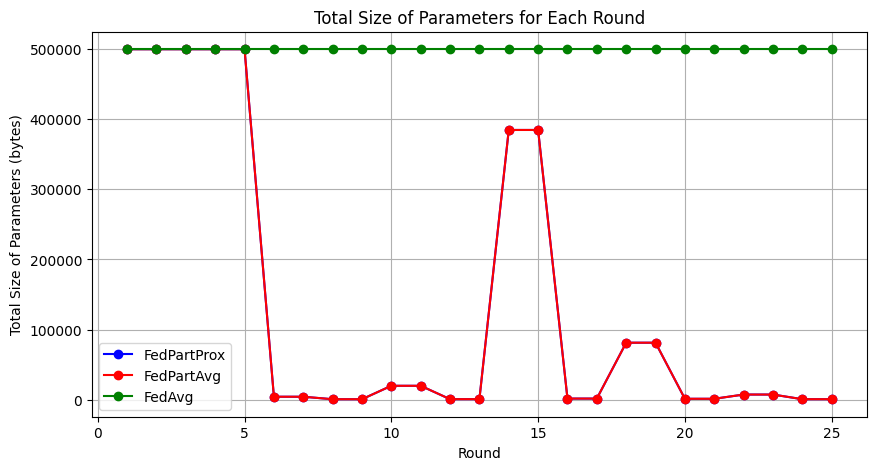

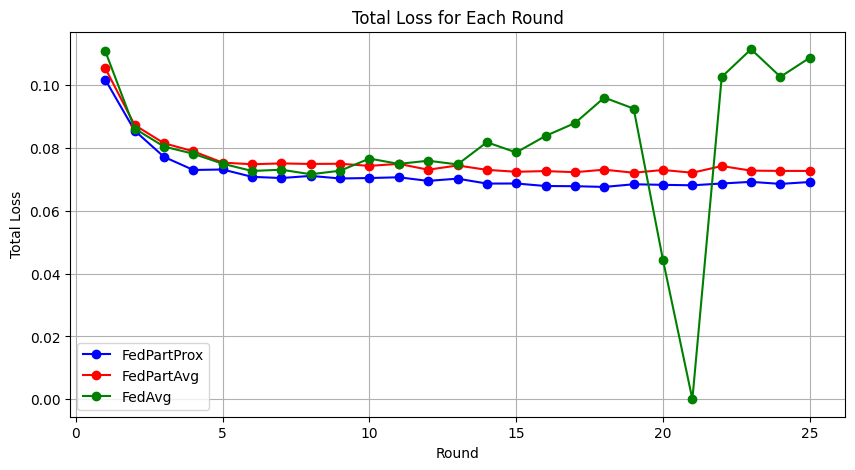

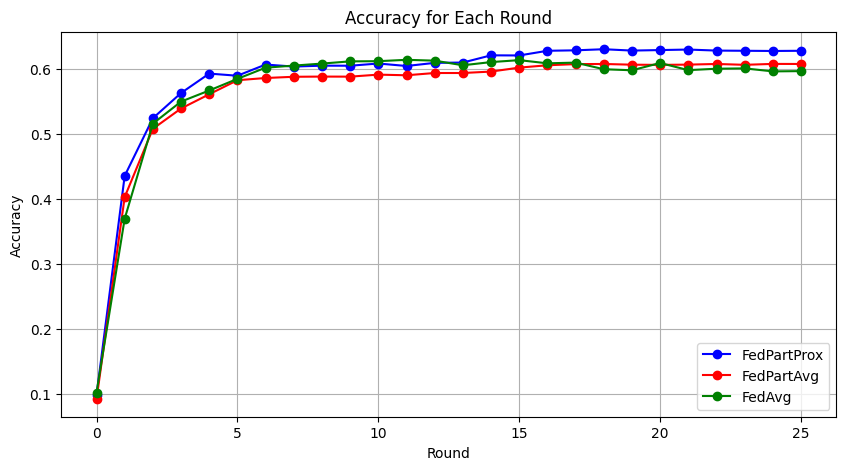

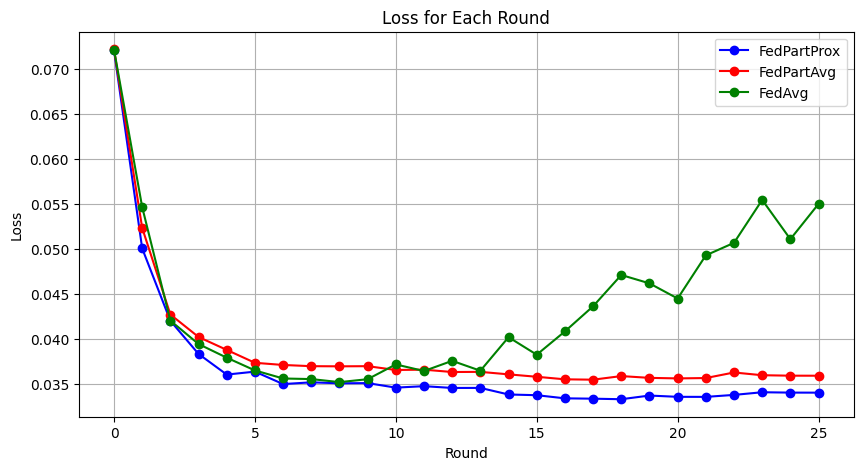

In [23]:
fed_part_prox_rounds = list(fed_part_prox_result.keys())
fed_part_prox_sizes = [fed_part_prox_result[round]["total_size"] for round in fed_part_prox_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_rounds, fed_part_prox_sizes, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.legend()
plt.grid(True)

fed_part_prox_losses = [fed_part_prox_result[round]["total_loss"] for round in fed_part_prox_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_rounds, fed_part_prox_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.legend()
plt.grid(True)


fed_part_prox_model_rounds = list(fed_part_prox_model_results.keys())
fed_part_prox_accuracies = [fed_part_prox_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_prox_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_part_prox_global_losses = [fed_part_prox_model_results[round]["global_loss"] for round in fed_part_prox_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')   
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss for Each Round')
plt.legend()
plt.grid(True)


